### Introducción
El objetivo final de este proyecto es predecir el sentimiento de un texto dado usando python, donde usamos NLTK, también conocido como Natural Language Processing Toolkit y de ser posible precisar el impacto causado por los comentarios positivos y negativos sobre un determinado comportamiento.

* Para este proyecto, importaremos un conjunto de librerías que se muestran a continuación
* Importaremos el conjunto de datos
* Realizaremos limpieza, formateo y visualización de los datos
* Construcción del modelo
* Predicción
* Medición de impacto 

In [3]:
# Importar librerías
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [23]:
# Importar datos
data = pd.read_csv('C:\\Users\\Joako\\Documents\\AnalisisDatos\\ReviewProject\\DatosOriginales\\reviews_filmaffinity.csv', delimiter='|', header=0)

In [24]:
data.shape

(8591, 6)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8591 entries, 0 to 8590
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8591 non-null   object 
 1   gender         8591 non-null   object 
 2   film_avg_rate  8591 non-null   object 
 3   review_rate    8589 non-null   float64
 4   review_title   8591 non-null   object 
 5   review_text    8591 non-null   object 
dtypes: float64(1), object(5)
memory usage: 402.8+ KB


In [26]:
data.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m..."
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll..."
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"Pero cuando amanece,y me quedo solo,siento en ..."


In [27]:
# Encontrar nulos
data.isnull().sum()

film_name        0
gender           0
film_avg_rate    0
review_rate      2
review_title     0
review_text      0
dtype: int64

In [28]:
# Eliminar nulos
data=data.dropna()

In [29]:
# Comprobando datos de la columna y noto que los valores contienen una coma y además son objetos. 
film=data['film_avg_rate'].unique()
print(film)


['6,0' '6,8' '4,4' '6,7' '4,8' '5,3' '6,5' '6,4' '7,2' '4,2' '6,9' '3,7'
 '5,7' '5,5' '7,7' '6,1' '5,8' '5,2' '5,4' '4,6' '5,0' '7,1' '3,9' '4,7'
 '5,1' '6,2' '6,6' '7,0']


In [30]:
# La columna film_avg_rate La convierto en float y remplazo ',' por '.'
data['film_avg_rate'] = data['film_avg_rate'].str.replace(',', '.').astype(float)


In [31]:
# comprobar rango de puntajes en la columna review_rate
rate=data['review_rate'].unique()
print(rate)

[ 3.  2.  8.  1.  6.  4.  5.  7.  9. 10.]


In [32]:
data.describe()

,film_avg_rate,review_rate
count,8589.000000,8589.000000
mean,6.186972,5.872744
std,0.991661,2.549188
min,3.700000,1.000000
25%,5.500000,4.000000
50%,6.500000,6.000000
75%,6.900000,8.000000
max,7.700000,10.000000


Crear una escala más manejable de los valores de review_rate en el que agruparemos siguiendo el criterio de normalidad que nos muestra la descripción de la tabla el 25 % de los puntajes estan entre 1-4, con lo cual los agrupamos con el puntaje 0 = 1,2,3,4 y los significamos como valores negativos. entre el 25% y el 75% se ubican los puntajes entre  5-8 y los agrupamos con el puntaje 1 = 5,6,7, significandolos neutrales y por encima del 75% los puntajes 9,10 que agrupamos en el puntaje 2 = 8,9,10 como positivos.

In [65]:
# Valoración calificaciones 

def clasificar_rate(n_review):
    if (n_review <= 4.0).all():
        return 'Negative'
    elif ((n_review > 4.0) & (n_review <= 7.0)).any():
        return 'Neutral'
    else:
        return 'Positive'
    
data['value_rate']= data.groupby(level=0)['review_rate'].apply(lambda x: clasificar_rate(x))

In [66]:
data.sample(5)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,value_rate
5702,Todo sobre mi madre,Drama,7.1,5.0,Sobreestimada.,"Es una película bien hecha, pues tiene el sell...",Neutral
2585,Mar adentro,Drama,7.2,2.0,Lo fácil es morir!!!!!!!!!!!!!,¡¡¡¡¡Estamos en el mundo al revés!!!!!! Los hé...,Negative
4457,El otro lado de la cama,Musical,6.4,2.0,¿Un musical?,No fuí al cine a ver esta película apesar de l...,Negative
4442,El otro lado de la cama,Musical,6.4,1.0,Comedia sin gracia y musical mal cantado,"Como dice el título dela crítica, estamos ante...",Negative
5293,Perdiendo el norte,Comedia,5.0,5.0,Los extraños resortes de la comedia.,Nacho G. Velilla parece haber estudiado bien l...,Neutral


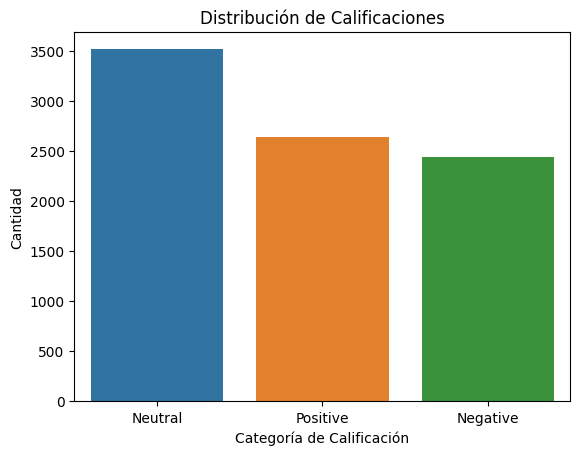

In [67]:
# Obtener la frecuencia de cada categoría
category_counts = data['value_rate'].value_counts()

# Crear el gráfico de barras
sns.barplot(x=category_counts.index, y=category_counts.values)

# Configurar los ejes y el título del gráfico
plt.xlabel('Categoría de Calificación')
plt.ylabel('Cantidad')
plt.title('Distribución de Calificaciones')

# Mostrar gráfico
plt.show()

In [80]:
#Simplificación de sentimientos
a=[]
for i, review_rate in enumerate(data['review_rate']):
    if review_rate <= 4.0:
        a.append(0)
    elif review_rate <= 7.0:
        a.append(1)
    elif review_rate > 7.0:
        a.append(2)
    else:
        print(f"Unmatched value at index {i}: {review_rate}")


        

In [88]:
a = [int(value) for value in a]

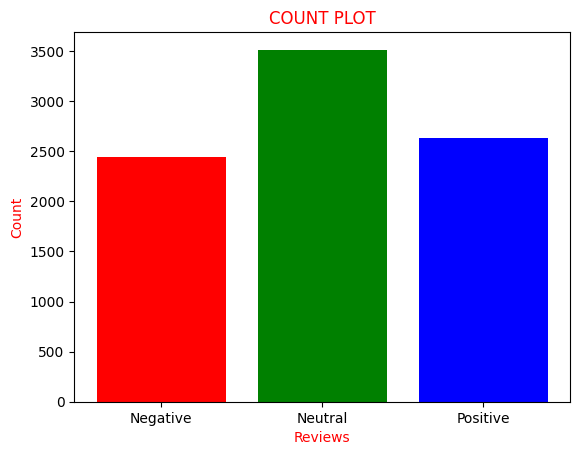

In [92]:
#Graficamos solo con matplotlib.pyplot porque seaborn esta dando un error

# Contar la frecuencia de cada categoría en 'a'
counts = [a.count(0), a.count(1), a.count(2)]

# Etiquetas de las categorías
labels = ['Negative', 'Neutral', 'Positive']

# Colores para las barras
colors = ['red', 'green', 'blue']

# Crear el gráfico de barras con colores diferentes
plt.bar(labels, counts, color=colors)
plt.xlabel('Reviews', color="red")
plt.ylabel('Count', color="red")
plt.title('COUNT PLOT', color="r")
plt.show()

In [93]:
data['sentiment']=a
final_dataset = data[['review_text', 'sentiment']]
print(final_dataset)

                                            review_text  sentiment
0     La mayor virtud de esta película es su existen...          0
1     No soy un experto cinéfilo, pero pocas veces m...          0
2     Si no eres un incondicional del humor estilo T...          0
3     No sé qué está pasando, si la gente se deja ll...          0
4     Pero cuando amanece,y me quedo solo,siento en ...          0
...                                                 ...        ...
8586  Buena no, lo siguiente. Por fin un film serio ...          2
8587  Me esperaba mucho, pero que mucho, más.Guión m...          0
8588  De mal cuerpo como sensación al finalizar, de ...          0
8589  Los que han añadido comentarios os lo han dich...          0
8590  Fui a ver esta película de cine con entusiasmo...          0

[8589 rows x 2 columns]


In [95]:
#Cuento cantidad de comentarios

data_p=final_dataset[data['sentiment']==2]
data_n=final_dataset[data['sentiment']==0]
len(data_n), len(data_p)

(2440, 2635)

In [99]:
#Selecciono la misma cantidad de comentarios positivos y negativos

datap = data_p.iloc[np.random.randint(0, len(data_p), 2400), :]
datan = data_n.iloc[np.random.randint(0, len(data_n), 2400), :]

len(datan), len(datap)

(2400, 2400)

In [100]:
# creo nuevo dataset con datos equivalentes para el modelo

data_sent = pd.concat([datap,datan])
len(data_sent)

4800